## **Loading libraries**

---



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import skewtest
from scipy.stats import median_test
from scipy.stats import ttest_1samp, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

import pylab
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);
# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

## **EDA**

---


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/A B Test/AdSmartABdata - AdSmartABdata.csv", parse_dates=['date'])
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


# **Description of variables**
* **auction_id:** the unique id of the online user who has been presented the BIO. In standard terminologies this is called an impression id. The user may see the BIO questionnaire but choose not to respond. In that case both the yes and no columns are zero.
* **experiment:** which group the user belongs to - control or exposed.  
*   **Control:** sers who have been shown a dummy ad.
*   **Exposed:** users who have been shown a creative, an online interactive ad, with the SmartAd brand.
* **date:**	the date in YYYY-MM-DD format
* **hour:**	the hour of the day in HH format
* **device_make:**	the name of the type of device the user has e.g. Samsung
* **platform_os:**	the id of the OS the user has.
* **browser:**	the name of the browser the user uses to see the BIO questionnaire.
* **yes:**	1 if the user chooses the “Yes” radio button for the BIO questionnaire.
* **no:**	1 if the user chooses the “No” radio button for the BIO questionnaire.


https://www.kaggle.com/datasets/osuolaleemmanuel/ad-ab-testing/data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   auction_id   8077 non-null   object        
 1   experiment   8077 non-null   object        
 2   date         8077 non-null   datetime64[ns]
 3   hour         8077 non-null   int64         
 4   device_make  8077 non-null   object        
 5   platform_os  8077 non-null   int64         
 6   browser      8077 non-null   object        
 7   yes          8077 non-null   int64         
 8   no           8077 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 568.0+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
hour,8077.0000,11.6151,5.7349,0.0000,7.0000,13.0000,15.0000,23.0000
platform_os,8077.0000,5.9471,0.2243,5.0000,6.0000,6.0000,6.0000,7.0000
yes,8077.0000,0.0708,0.2565,0.0000,0.0000,0.0000,0.0000,1.0000
no,8077.0000,0.0831,0.2760,0.0000,0.0000,0.0000,0.0000,1.0000


In [ ]:
df.isnull().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [ ]:
df.nunique()

auction_id     8077
experiment        2
date              8
hour             24
device_make     269
platform_os       3
browser          15
yes               2
no                2
dtype: int64

In [ ]:
# Check and codify categorical values

device_list_codified = []
for x in df.device_make:
    if 'Samsung' in x:
        device_list_codified.append(1)
    elif 'iPhone' in x:
        device_list_codified.append(2)
    else:
        device_list_codified.append(0)
df.device_make = device_list_codified

browser_list_codified = []
for x in df.browser:
    if 'Chrome' in x:
        browser_list_codified.append(1)
    elif 'Safari' in x:
        browser_list_codified.append(2)
    else:
        browser_list_codified.append(0)
df.browser = browser_list_codified

del device_list_codified, browser_list_codified

# Prinitng processed df
print('# Observations: {}'.format(df.shape[0]))
print('# Variables: {}'.format(df.shape[1]))
df.head()

# Observations: 8077
# Variables: 9


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,0,6,1,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,0,6,1,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,0,6,1,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,1,6,0,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,0,6,1,0,0


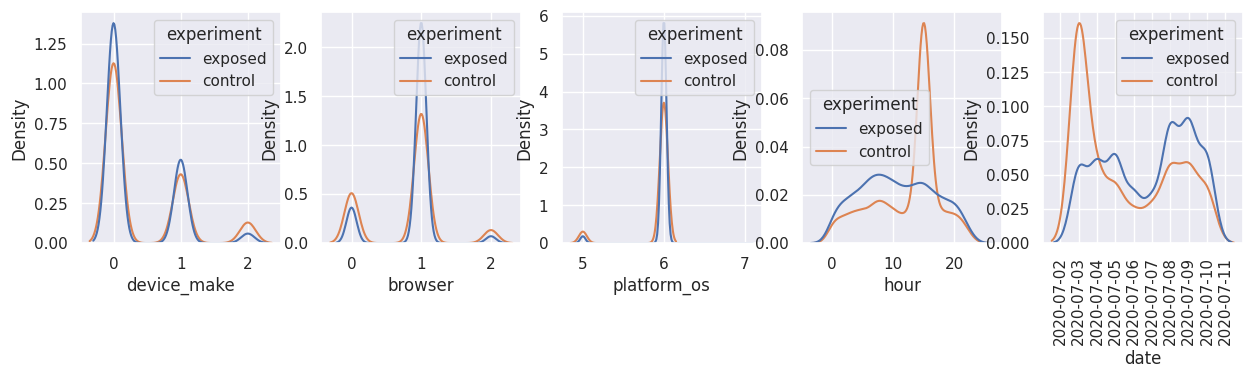

In [ ]:
# Distributions for categorical variables
fig, ax = plt.subplots(1,5)
sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(x='device_make', hue='experiment', data=df, ax=ax[0])
sns.kdeplot(x='browser', hue='experiment', data=df, ax=ax[1])
sns.kdeplot(x='platform_os', hue='experiment', data=df, ax=ax[2])
sns.kdeplot(x='hour', hue='experiment', data=df, ax=ax[3])
sns.kdeplot(x='date', hue='experiment', data=df, ax=ax[4])
plt.xticks(rotation=90)
plt.show()
plt.close()

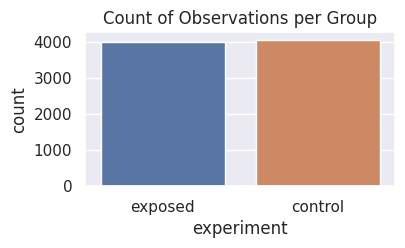

In [ ]:
# Sample sizes
sns.set(rc={'figure.figsize':(4,2)})
sns.countplot(x='experiment', data=df)
plt.title('Count of Observations per Group')
plt.show()
plt.close()

Control and exposed properly represent the population, this can be seen on the fact that 'device_make', 'browser' and 'platform_os' present almost equal distributions for both results. This is a good sign, as it shows that the population partition between the control and exposed group has been performed in a way where both groups are representative of the total population

In [ ]:
df_mod = df.drop(df.columns[[0,4,5,6]], axis=1, inplace=False) # REMOVE columns [[0,2,3,4,5,6]] from ORIGINAL dataframe, **df**
df_participants = df_mod[(df_mod['yes'] == 1) | (df_mod['no'] == 1)] # KEEP PARTICIPATING MEMBERS ONLY
print('\nDimensions of Participants dataframe =', df_participants.shape)

df_participants.head()


Dimensions of Participants dataframe = (1243, 5)


,experiment,date,hour,yes,no
2,exposed,2020-07-05,2,0,1
16,exposed,2020-07-04,16,1,0
20,exposed,2020-07-06,8,0,1
23,control,2020-07-08,4,1,0
27,control,2020-07-03,15,0,1


**Checking the data shrinkage**

In [ ]:
print('The usefull percentage of sample is:', round((len(df_participants)/len(df))*100,2) , '%')

The usefull percentage of sample is: 15.39 %


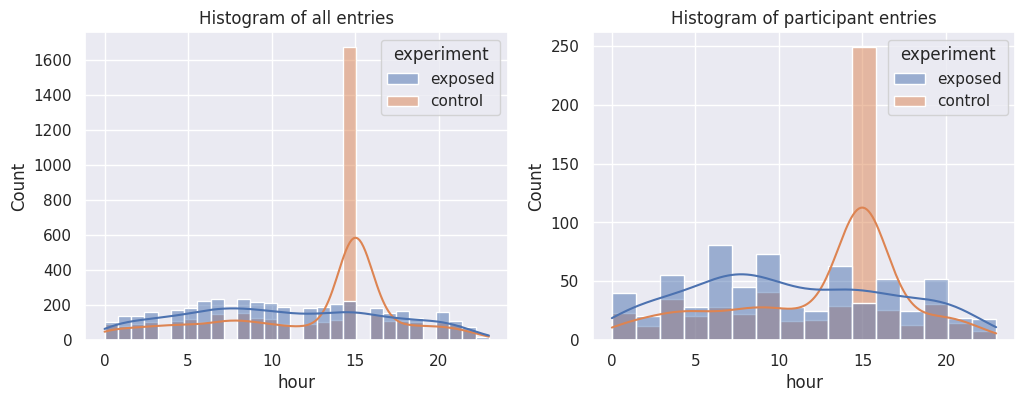

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ax1 = sns.histplot(data=df, ax=ax[0], x='hour', hue='experiment', multiple='layer', kde=True)
ax2 = sns.histplot(data=df_participants, ax=ax[1], x='hour', hue='experiment', multiple='layer', kde=True)
ax1.set_title('Histogram of all entries')
ax2.set_title('Histogram of participant entries')

plt.show()

## **Test A/B**

---


**Step 1 - Formulate Hypotheses:**



*   Null Hypothesis (H0): μ1 = μ2 (There is no statistical difference in mean value between the Control and Variant Groups)
*   Alternative Hypothesis (H1): μ1 ≠ μ2 (There is a statistical difference in the mean value between the Control and Variant Groups)

**Step 2 - Assumption Checks:**

*   Normality Assumption
*   Homogeneity of Variance

**Step 3 - Normality Assumption Hypothesis:**

*   H0: The normal distribution assumption is met.
*   H1: The normal distribution assumption is not met.

**Step 4 - Assumption of Homogeneity of Variance:**

*   H0: Variances are homogenous.
*   H1: Variances are not homogenous.

In [ ]:
print("Normality asumption \n")
print("Shapiro Wilks Test Result \n")
for x in df_participants["experiment"].unique():
    test_statistic, pvalue = shapiro(df_participants.loc[df_participants["experiment"] == x, "yes"])
    if (pvalue<0.05):
        print(f'{x}:')
        print('Test statistic = %.4f, p-value = %.4f' % (test_statistic, pvalue), "H0 is rejected")
    else:
        print(f'{x}:')
        print('Test statistic = %.4f, p-value = %.4f' % (test_statistic, pvalue), "H0 is not rejected")

Normality asumption 

Shapiro Wilks Test Result 

exposed:
Test statistic = 0.6351, p-value = 0.0000 H0 is rejected
control:
Test statistic = 0.6330, p-value = 0.0000 H0 is rejected


*   H0 has been rejected. It does not exhibit a normal distribution.
*   Therefore, there is no need to check for homogeneity of variances. We can proceed directly to non-parametric statistical analysis, which is the Mann-Whitney test.

In [ ]:
print('Mann-Whitney test')

test_statistic, p = mannwhitneyu(df_participants.loc[df_participants['experiment'] == "exposed",'yes'],
                                          df_participants.loc[df_participants['experiment'] == "control",'yes'])

print(f"\nStatistic: {test_statistic:.3f}\np-Value: {pvalue:.3f}\n")

Mann-Whitney test

Statistic: 196021.000
p-Value: 0.000



According to the Mann-Whitney U test, H0 is rejected. There is significant difference between the means of the two groups; However, possible biases in the dataset, that could alter the test results, must be evaluated.

In [ ]:
# Creating dfs for each group
df_control = df_participants[df.experiment =='control']
df_exposed = df_participants[df.experiment =='exposed']

# Computing mean (as success == 1 and failure == 0 the mean is effectively our success rate)
mean_success_control = df_control.yes.mean()
mean_success_exposed = df_exposed.yes.mean()

# Printing results
print('Ad Success Control group {}%'.format((mean_success_control*100).round(2)))
print('Ad Success Exposed group {}%'.format((mean_success_exposed*100).round(2)))

Ad Success Control group 45.05%
Ad Success Exposed group 46.88%


## **Evaluation of date and hour distributions**

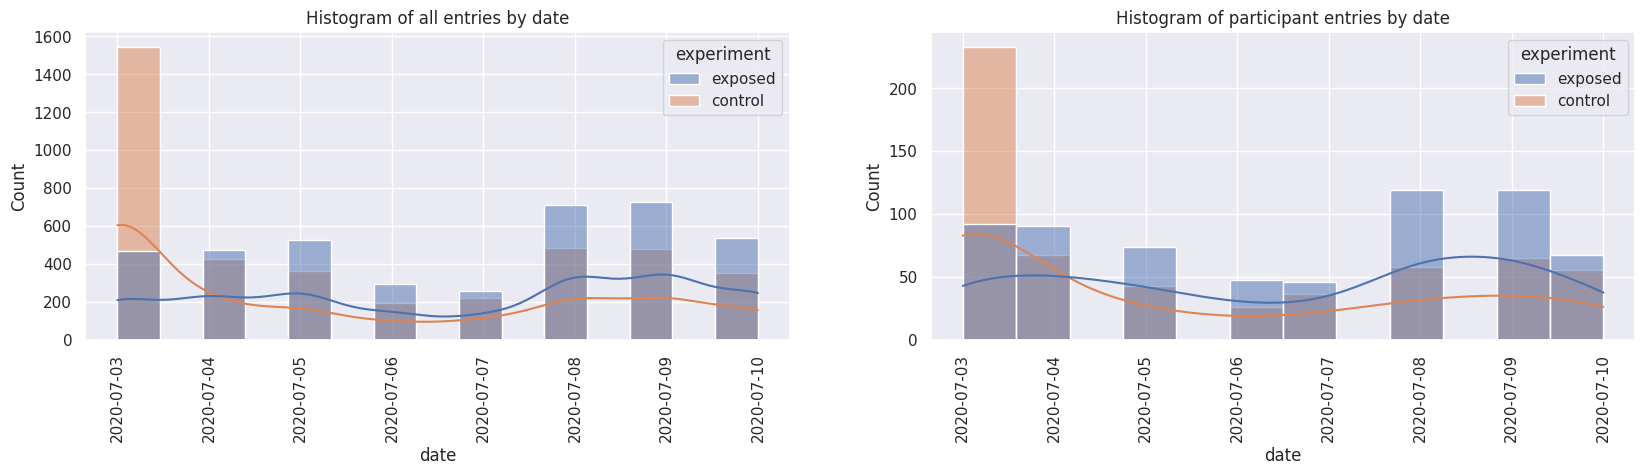

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(20,4))
ax1 = sns.histplot(data=df, ax=ax[0], x='date', hue='experiment', multiple='layer', kde=True)
ax2 = sns.histplot(data=df_participants, ax=ax[1], x='date', hue='experiment', multiple='layer', kde=True)
ax1.set_title('Histogram of all entries by date')
ax2.set_title('Histogram of participant entries by date')
for axes in [ax1, ax2]:
    axes.tick_params(axis='x', rotation=90)
plt.show()

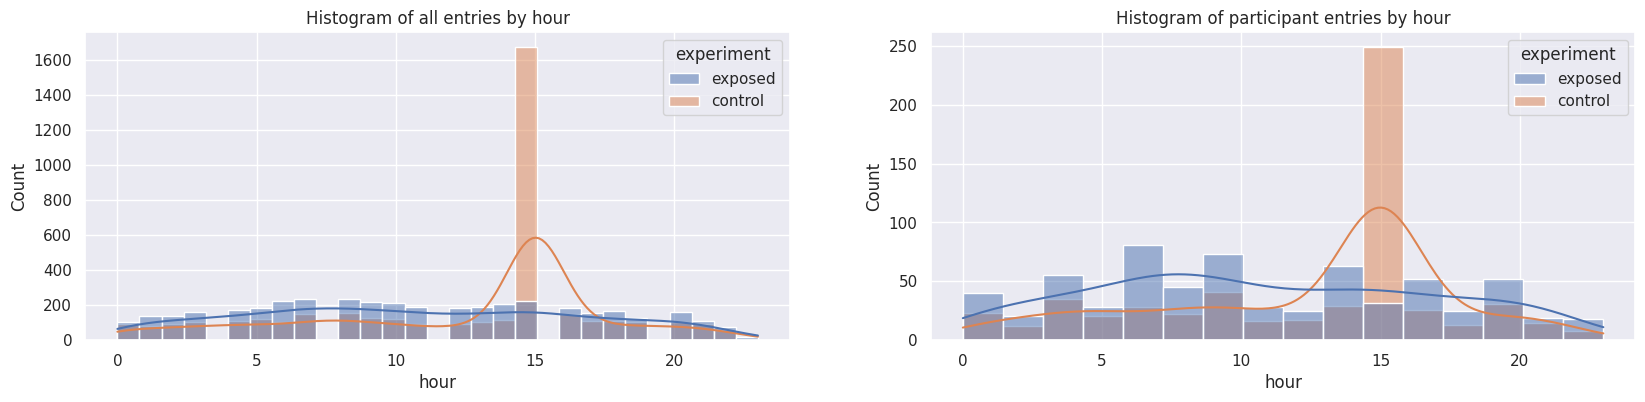

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(20,4))
ax1 = sns.histplot(data=df, ax=ax[0], x='hour', hue='experiment', multiple='layer', kde=True)
ax2 = sns.histplot(data=df_participants, ax=ax[1], x='hour', hue='experiment', multiple='layer', kde=True)
ax1.set_title('Histogram of all entries by hour')
ax2.set_title('Histogram of participant entries by hour')
plt.show()

Similar patterns can be observed for the full dataset as for the useful dataset. We will then proceed to evaluate the date 2020-07-03 and the time "15", where the greatest deviations are observed.

In [ ]:
print('Evaluating dataset without the date 2020-07-03')
filtro = (df_participants['date'] == '2020-07-03')
df2 = df_participants[~filtro]
df2.head()

Evaluating dataset without the date 2020-07-03


,experiment,date,hour,yes,no
2,exposed,2020-07-05,2,0,1
16,exposed,2020-07-04,16,1,0
20,exposed,2020-07-06,8,0,1
23,control,2020-07-08,4,1,0
39,exposed,2020-07-10,2,0,1


In [ ]:
print('Checking if all the entries with date 2020-07-03 have been deleted')
print(df_participants['date'].nunique())
print(df2['date'].nunique())


Checking if all the entries with date 2020-07-03 have been deleted
8
7


                                              Histograms of date and hour without date 2020-07-03


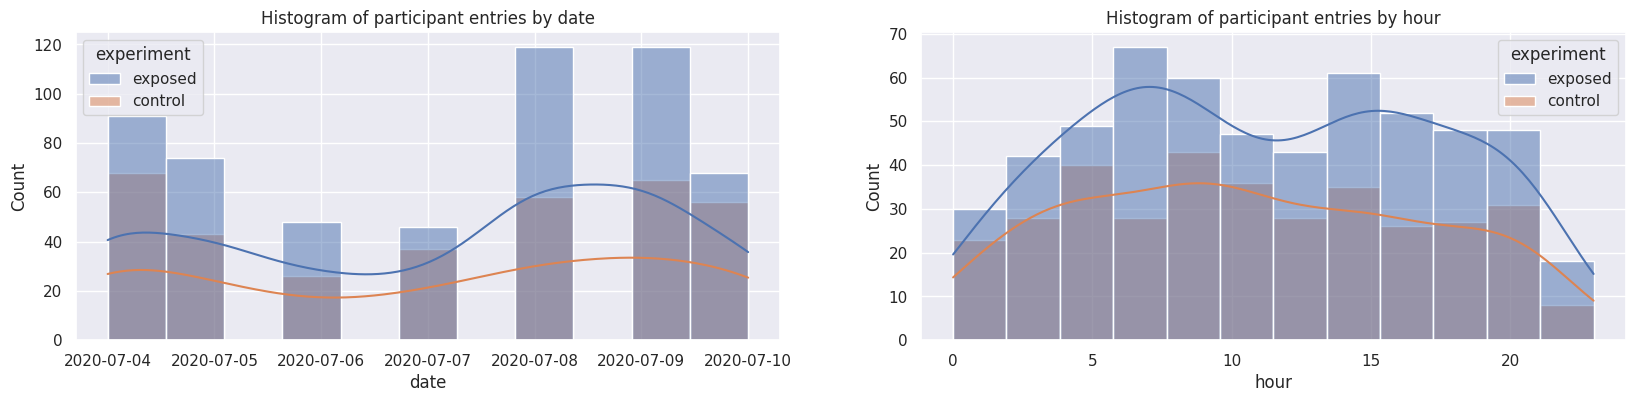

In [ ]:
print('                                              Histograms of date and hour without date 2020-07-03')

fig, ax = plt.subplots(ncols=2, figsize=(20,4))
ax1 = sns.histplot(data=df2, ax=ax[0], x='date', hue='experiment', multiple='layer', kde=True)
ax2 = sns.histplot(data=df2, ax=ax[1], x='hour', hue='experiment', multiple='layer', kde=True)
ax1.set_title('Histogram of participant entries by date')
ax2.set_title('Histogram of participant entries by hour')

plt.show()

We can see that the distribution of de polts improves by eliminating date 2020-07-03

In [ ]:
fecha_deseada = '2020-07-03'
filtro_fecha = df_participants['date'] == fecha_deseada

# Filtrar el DataFrame para la fecha específica
df_fecha = df_participants[filtro_fecha]

# Contar las ocurrencias de cada hora en la fecha específica
conteo_horas = df_fecha['hour'].value_counts()

# Obtener la hora con más apariciones
hora_mas_frecuente = conteo_horas.idxmax()

# Imprimir el resultado
print(f"Analyzing 'hour' feature for date {fecha_deseada}, the most frequent time is: {hora_mas_frecuente}")

Analyzing 'hour' feature for date 2020-07-03, the most frequent time is: 15


In [ ]:
filtro2 = (df['date'] == '2020-07-03') &  (df['hour'] == 15)
df3 = df_participants[~filtro2]
df3.head()

,experiment,date,hour,yes,no
2,exposed,2020-07-05,2,0,1
16,exposed,2020-07-04,16,1,0
20,exposed,2020-07-06,8,0,1
23,control,2020-07-08,4,1,0
39,exposed,2020-07-10,2,0,1


In [ ]:
print(df_participants.shape)
print(df2.shape)
print(df3.shape)

(1243, 5)
(918, 5)
(1011, 5)


                                              Histograms of date and whit and without hour 15


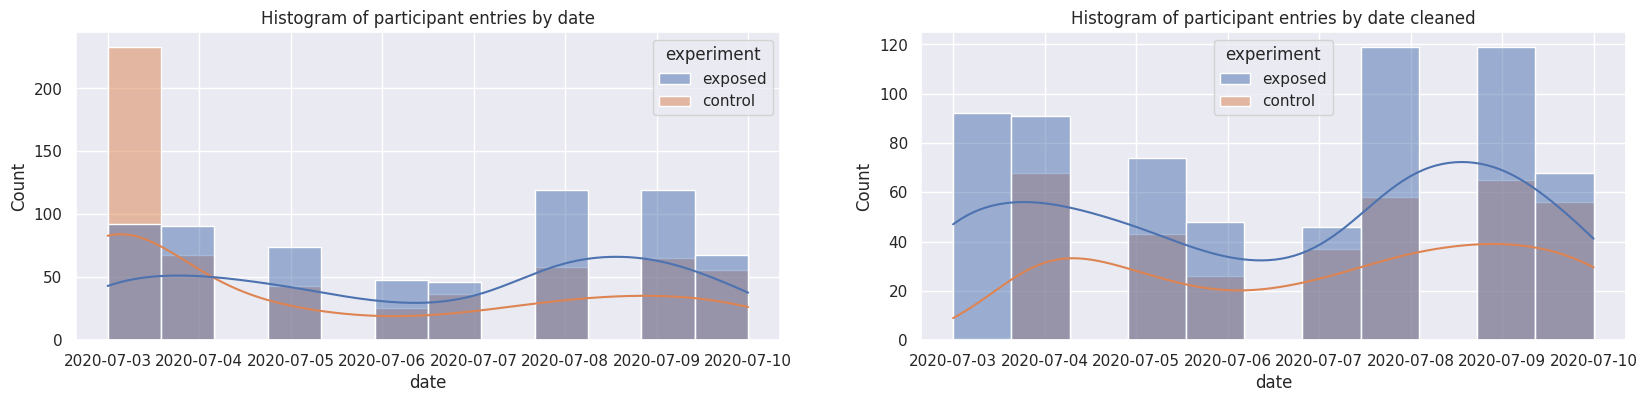

In [ ]:
print('                                              Histograms of date and whit and without hour 15')

fig, ax = plt.subplots(ncols=2, figsize=(20,4))
ax1 = sns.histplot(data=df_participants, ax=ax[0], x='date', hue='experiment', multiple='layer', kde=True)
ax2 = sns.histplot(data=df3, ax=ax[1], x='date', hue='experiment', multiple='layer', kde=True)
ax1.set_title('Histogram of participant entries by date')
ax2.set_title('Histogram of participant entries by date cleaned')

plt.show()

In [ ]:
df_participants2 = df_participants[df_participants['date'] == '2020-07-03']
print(df_participants2.shape)
print(df_participants2.head())

(325, 5)
   experiment       date  hour  yes  no
27    control 2020-07-03    15    0   1
45    control 2020-07-03    15    1   0
48    control 2020-07-03    15    0   1
56    exposed 2020-07-03    14    0   1
62    control 2020-07-03    15    0   1


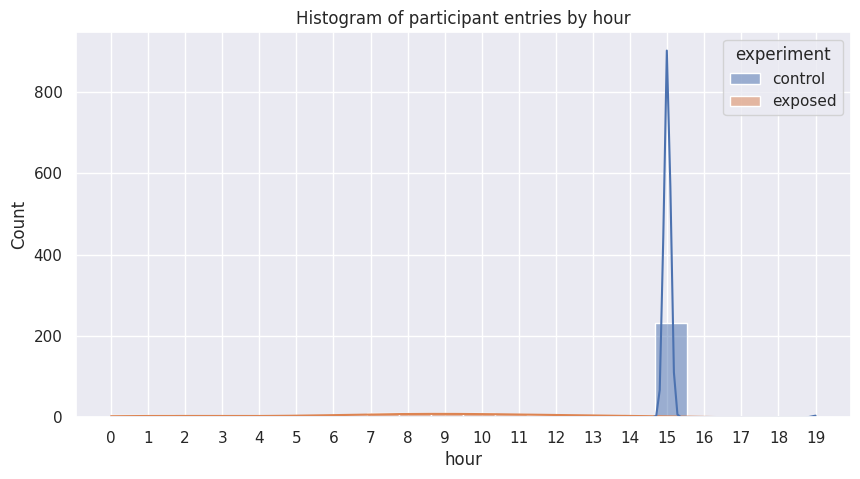

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.histplot(data=df_participants2, x='hour', hue='experiment', multiple='layer', kde=True)
plt.xticks(range(int(df_participants2['hour'].min()), int(df_participants2['hour'].max()) + 1, 1))
ax.set_title('Histogram of participant entries by hour')
plt.show()

It is interesting to note that when eliminating the entries corresponding to hour 15, the most affected date is 2020-07-03.
Furthermore, a very unbalanced peak can be observed at hour 15 for the control group.

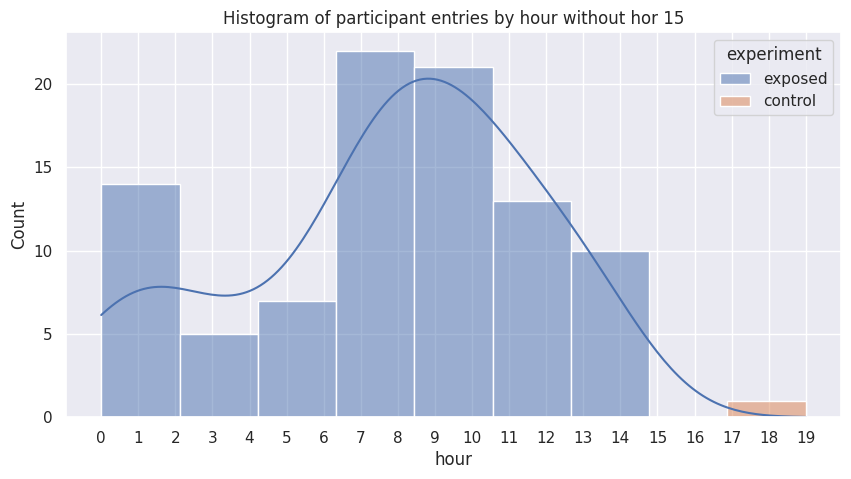

In [ ]:
filtro3 = (df_participants2['hour'] == 15)
df_participants3 = df_participants2[~filtro3]
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.histplot(data=df_participants3, x='hour', hue='experiment', multiple='layer', kde=True)
plt.xticks(range(int(df_participants2['hour'].min()), int(df_participants2['hour'].max()) + 1, 1))
ax.set_title('Histogram of participant entries by hour without hor 15')
plt.show()

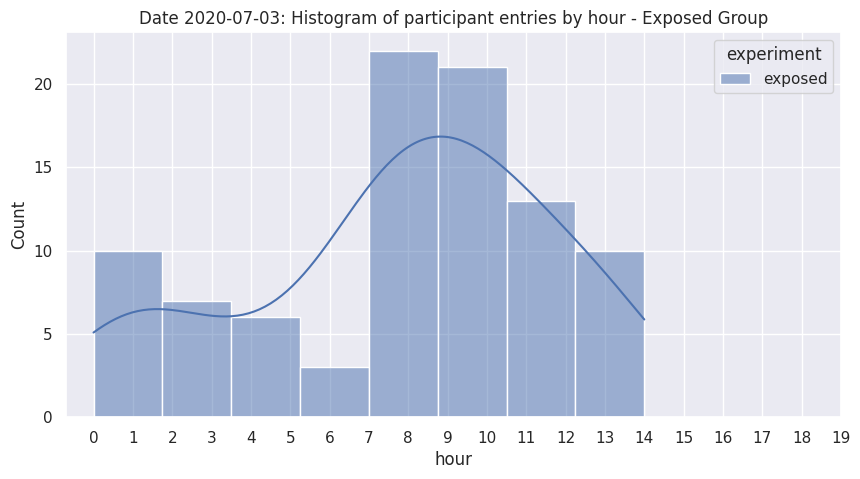

In [ ]:
filtro3 = (df_participants2['experiment'] == 'control')
df_participants3 = df_participants2[~filtro3]
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.histplot(data=df_participants3, x='hour', hue='experiment', multiple='layer', kde=True)
plt.xticks(range(int(df_participants2['hour'].min()), int(df_participants2['hour'].max()) + 1, 1))
ax.set_title('Date 2020-07-03: Histogram of participant entries by hour - Exposed Group')
plt.show()

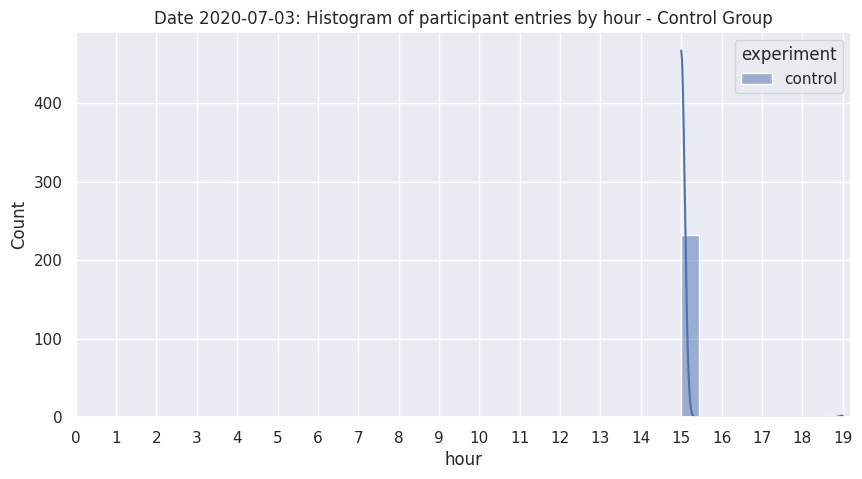

In [ ]:
filtro3 = (df_participants2['experiment'] == 'exposed')
df_participants3 = df_participants2[~filtro3]
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.histplot(data=df_participants3, x='hour', hue='experiment', multiple='layer', kde=True)
plt.xticks(range(int(df_participants2['hour'].min()), int(df_participants2['hour'].max()) + 1, 1))
ax.set_title('Date 2020-07-03: Histogram of participant entries by hour - Control Group')
plt.show()

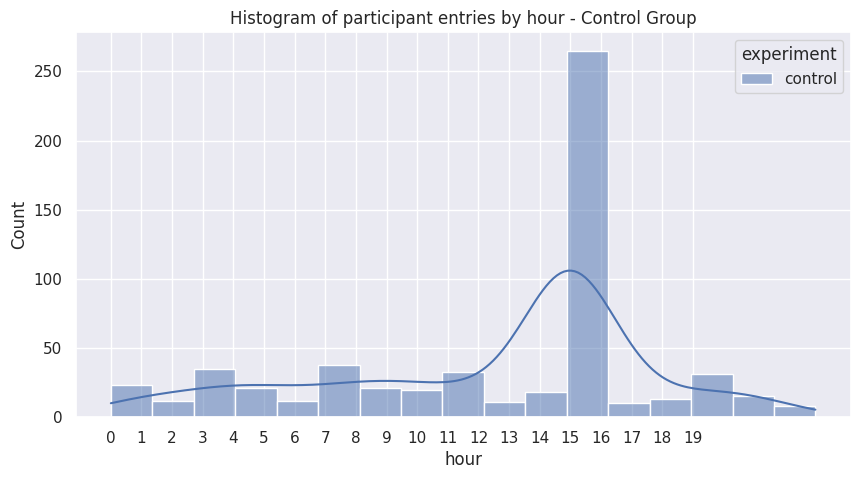

In [ ]:
filtro3 = (df_participants['experiment'] == 'exposed')
df_participants3 = df_participants[~filtro3]
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.histplot(data=df_participants3, x='hour', hue='experiment', multiple='layer', kde=True)
plt.xticks(range(int(df_participants2['hour'].min()), int(df_participants2['hour'].max()) + 1, 1))
ax.set_title('Histogram of participant entries by hour - Control Group')
plt.show()

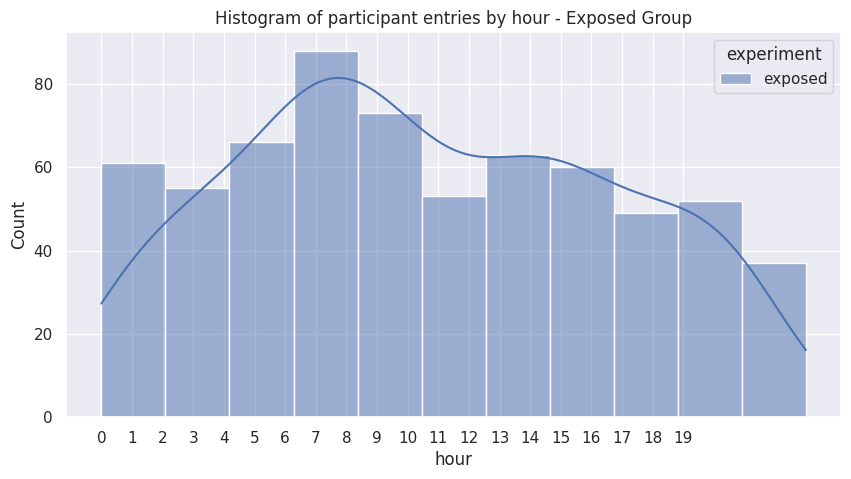

In [ ]:
filtro3 = (df_participants['experiment'] == 'control')
df_participants3 = df_participants[~filtro3]
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.histplot(data=df_participants3, x='hour', hue='experiment', multiple='layer', kde=True)
plt.xticks(range(int(df_participants2['hour'].min()), int(df_participants2['hour'].max()) + 1, 1))
ax.set_title('Histogram of participant entries by hour - Exposed Group')
plt.show()


Two new A/B tests can be carried out, one eliminating the entries corresponding to the date '2020-07-03' and another eliminating the entries corresponding to hour '15'.The decision to eliminate these values ​is due to the fact that they are what unbalance the sample in one of the groups (Control) and thereby bias the methodology of the Mann-Whitney statistical test. Following this line of thinking, the most sensible decision is to only delete the data corresponding to the date '2020-07-03' and not those of the 15th hour, since in the latter case an error would be introduced in all the other date entries.

## **Test A/B: without date 2020-07-03**

---


**Step 1 - Formulate Hypotheses:**



*   Null Hypothesis (H0): μ1 = μ2 (There is no statistical difference in terms of revenue between the Control and Variant Groups)
*   Alternative Hypothesis (H1): μ1 ≠ μ2 (There is a statistical difference between the Control and Variant Groups in terms of revenue)

**Step 2 - Assumption Checks:**

*   Normality Assumption
*   Homogeneity of Variance

**Step 3 - Normality Assumption Hypothesis:**

*   H0: The normal distribution assumption is met.
*   H1: The normal distribution assumption is not met.

**Step 4 - Assumption of Homogeneity of Variance:**

*   H0: Variances are homogenous.
*   H1: Variances are not homogenous.

In [ ]:
print("Normality asumption \n")
print("Shapiro Wilks Test Result \n")
for x in df2["experiment"].unique():
    test_statistic, pvalue = shapiro(df2.loc[df2["experiment"] == x, "yes"])
    if (pvalue<0.05):
        print(f'{x}:')
        print('Test statistic = %.4f, p-value = %.4f' % (test_statistic, pvalue), "H0 is rejected")
    else:
        print(f'{x}:')
        print('Test statistic = %.4f, p-value = %.4f' % (test_statistic, pvalue), "H0 is not rejected")

Normality asumption 

Shapiro Wilks Test Result 

exposed:
Test statistic = 0.6352, p-value = 0.0000 H0 is rejected
control:
Test statistic = 0.6333, p-value = 0.0000 H0 is rejected


*   H0 has been rejected. It does not exhibit a normal distribution.
*   Therefore, there is no need to check for homogeneity of variances. We can proceed directly to non-parametric statistical analysis, which is the Mann-Whitney test."

In [ ]:
s,p = mannwhitneyu(df2.loc[df2['experiment'] == "exposed","yes"],
                    df2.loc[df2['experiment'] == "control","yes"])
print(f"\nStatistic: {s:.3f}\np-Value: {p:.3f}\n")


Statistic: 101295.000
p-Value: 0.641



According to the Mann-Whitney U test, H0 cannot be rejected. There is no significant difference between the means of the two group

In [ ]:
# Creating dfs for each group
df_control = df2[df.experiment =='control']
df_exposed = df2[df.experiment =='exposed']

# Computing mean (as success == 1 and failure == 0 the mean is effectively our success rate)
mean_success_control = df_control.yes.mean()
mean_success_exposed = df_exposed.yes.mean()

# Printing results
print('Ad Success Control group {}%'.format((mean_success_control*100).round(2)))
print('Ad Success Exposed group {}%'.format((mean_success_exposed*100).round(2)))

Ad Success Control group 45.33%
Ad Success Exposed group 46.9%


## **Conclusions**

---
**The following observations were found:**

* Of the 8077 (100%) available entries, only 1243 (15%) were useful for statistical analysis
* Anomalous data are observed that directly influence the results
* When using the data provided without questioning the design of the experiment, the 'exposed' group achieves better results

* When using the data provided after cleaning possible anomalous data, no statistical differences are found that support one questionnaire over another.

**Recommendations:**

Based on the analysis, it is recommended to perform the experiment again and extending its duration, with the aim of increasing the volume of data and ensuring that the data is free of bias.

With the existing data, the new questionnaire (exposed) is not recommended over the old one (control) since the lacking of the necessary statistical evidence.